In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from path_explain import utils
utils.set_up_environment(visible_devices='3')

In [4]:
import tensorflow as tf
import tensorflow_datasets
import numpy as np
import scipy
from transformers import *
from plot.text import text_plot, matrix_interaction_plot, bar_interaction_plot
from plot.scatter import _set_axis_config
from plot import colors

## Data and Model Loading

In [5]:
task = 'sst-2'
num_labels = len(glue_processors[task]().get_labels())

In [6]:
config = DistilBertConfig.from_pretrained('.', num_labels=num_labels)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('.', config=config)

In [6]:
sentences = [
    'This movie was bad',
    'This movie was not bad',
    'A movie',
    'A bad movie',
    'A bad, terrible movie',
    'A bad, terrible, awful movie',
    'A bad, terrible, awful, horrible movie'
]

input_ids_all = []
token_type_ids_all = []
attention_mask_all = []

for sentence in sentences:
    encoded_sentence = tokenizer.encode_plus(sentence,
                                             add_special_tokens=True,
                                             return_tensors='tf',
                                             pad_to_max_length=True,
                                             max_length=128)
    input_ids = encoded_sentence['input_ids']
    token_type_ids = encoded_sentence['token_type_ids']
    attention_mask = encoded_sentence['attention_mask']

    input_ids_all.append(input_ids)
    token_type_ids_all.append(token_type_ids)
    attention_mask_all.append(attention_mask)

batch_input = {
    'input_ids': tf.concat(input_ids_all, axis=0),
    'token_type_ids': tf.concat(token_type_ids_all, axis=0),
    'attention_mask': tf.concat(attention_mask_all, axis=0)
}

## Model Evaluation

In [7]:
batch_conf = model(batch_input)[0]
batch_conf = scipy.special.softmax(batch_conf, axis=-1)
batch_pred = np.argmax(batch_conf, axis=-1)
batch_labels = [0, 1, 1, 0, 0, 0, 0]
batch_ids = batch_input['input_ids']
batch_baseline = np.zeros((1, 128), dtype=np.int64)

In [8]:
def embedding_model(batch_ids):
    batch_embedding = model.distilbert.embeddings(batch_ids)
    return batch_embedding

def prediction_model(batch_embedding):
    attention_mask = tf.ones(batch_embedding.shape[:2])
    attention_mask = tf.cast(attention_mask, dtype=tf.float32)
    head_mask = [None] * model.distilbert.num_hidden_layers

    transformer_output = model.distilbert.transformer([batch_embedding, attention_mask, head_mask], training=False)[0]
    pooled_output = transformer_output[:, 0]
    pooled_output = model.pre_classifier(pooled_output)
    logits = model.classifier(pooled_output)
    return logits

In [9]:
batch_embedding = embedding_model(batch_ids)

In [10]:
baseline_embedding = embedding_model(batch_baseline)

In [11]:
batch_predictions = prediction_model(batch_embedding)

## Model Interpretation

In [12]:
def print_sentence(index):
    confidence = batch_conf[index]
    predicted_label = batch_pred[index]
    true_label = batch_labels[index]

    encoded_sentence = batch_ids[index].numpy()
    encoded_sentence = encoded_sentence[encoded_sentence != 0]

    print(tokenizer.decode(encoded_sentence))
    print('This sentence is:\t{}'.format('positive' if true_label == 1 else 'negative'))
    print('DistilBERT predicts:\t{} (confidence {:.4f})'.format('positive' if predicted_label == 1 else 'negative',
                                                           batch_conf[index, predicted_label]))
    print('-------------------------')

In [13]:
for i in range(batch_ids.shape[0]):
    print_sentence(i)

[CLS] this movie was bad [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9982)
-------------------------
[CLS] this movie was not bad [SEP]
This sentence is:	positive
DistilBERT predicts:	positive (confidence 0.9819)
-------------------------
[CLS] a movie [SEP]
This sentence is:	positive
DistilBERT predicts:	positive (confidence 0.9940)
-------------------------
[CLS] a bad movie [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9981)
-------------------------
[CLS] a bad, terrible movie [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9983)
-------------------------
[CLS] a bad, terrible, awful movie [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9984)
-------------------------
[CLS] a bad, terrible, awful, horrible movie [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9984)
-------------------------


In [14]:
attributions = np.load('attributions_custom.npy')
interactions = np.load('interactions_custom.npy')

In [15]:
orig_token_list = []
for i in range(batch_ids.shape[0]):
    ids = batch_ids[i].numpy()
    tokens = tokenizer.convert_ids_to_tokens(ids)
    orig_token_list.append(tokens)

In [16]:
token_list, attribution_list, interaction_list = utils.strip_tokens(orig_token_list, attributions, interactions)

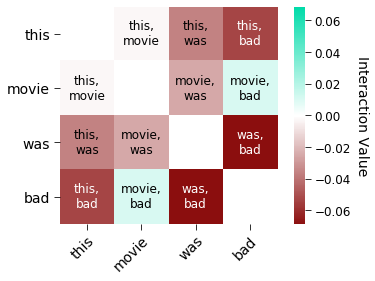

In [58]:
im, cbar = matrix_interaction_plot(interaction_list[0], token_list[0])
plt.savefig('movie_bad.pdf')

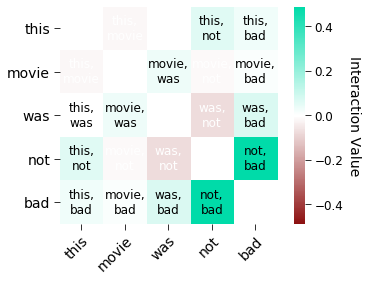

In [59]:
im, cbar = matrix_interaction_plot(interaction_list[1], token_list[1])
plt.savefig('movie_not_bad.pdf')

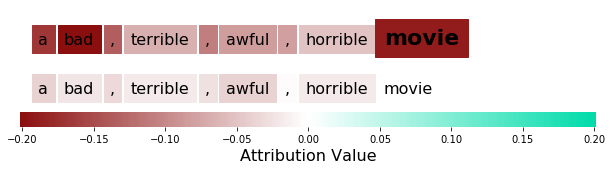

In [67]:
text_plot(token_list[6], attribution_list[6], include_legend=True, interaction_matrix=interaction_list[6], interaction_index=8)
plt.savefig('explaining_the_word_movie.pdf')

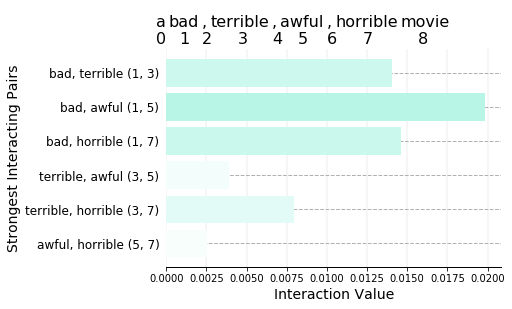

In [89]:
ax, text_ax = bar_interaction_plot(interaction_list[6],
                                   token_list[6],
                                   pair_indices=[(1, 3),
                                                 (1, 5),
                                                 (1, 7),
                                                 (3, 5),
                                                 (3, 7),
                                                 (5, 7)])
plt.savefig('saturation_effects_in_language.pdf')

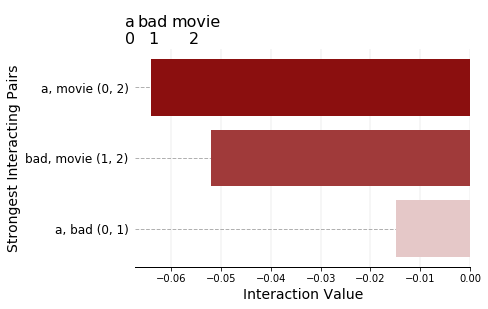

In [91]:
ax, text_ax = bar_interaction_plot(interaction_list[3],
                                   token_list[3],
                                   top_k=3)
plt.savefig('increasing_saturation_1.pdf')

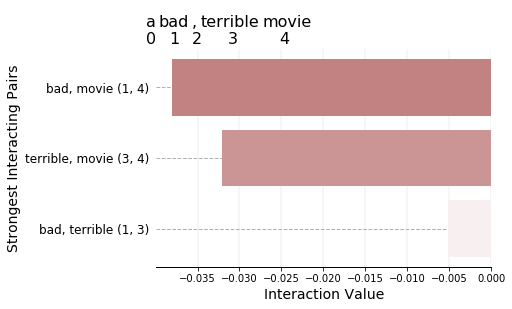

In [92]:
ax, text_ax = bar_interaction_plot(interaction_list[4],
                                   token_list[4],
                                   pair_indices=[(1, 4),
                                                 (3, 4),
                                                 (1, 3)])
plt.savefig('increasing_saturation_2.pdf')

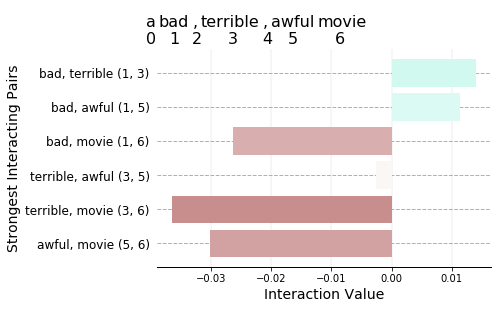

In [93]:
ax, text_ax = bar_interaction_plot(interaction_list[5],
                                   token_list[5],
                                   pair_indices=[(1, 3),
                                                 (1, 5),
                                                 (1, 6),
                                                 (3, 5),
                                                 (3, 6),
                                                 (5, 6)])
plt.savefig('increasing_saturation_3.pdf')

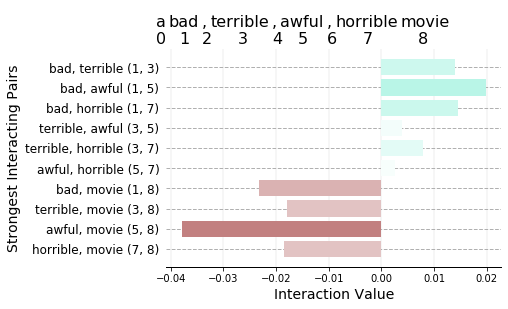

In [94]:
ax, text_ax = bar_interaction_plot(interaction_list[6],
                                   token_list[6],
                                   pair_indices=[(1, 3),
                                                 (1, 5),
                                                 (1, 7),
                                                 (3, 5),
                                                 (3, 7),
                                                 (5, 7),
                                                 (1, 8),
                                                 (3, 8),
                                                 (5, 8),
                                                 (7, 8)])
plt.savefig('increasing_saturation_4.pdf')